In [1]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [2]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note id', 'person id', 'surgeon estimated op time', 'final op name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition source value']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical department', 'op timing', 'month', 'anesthesia type', 'op code',
                'day of the week', 'asa class', 'week of the month', 
                'division', 'previous surgery', 'emergency status', 'gender source value', 'surgeon id', 'ward', 
                'admission department', 'surgery room']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery duration", axis=1)
y_all = df_encoded["surgery duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery duration, Length: 128975, dtype: int64

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Preparing department-specific datasets
departments = df['surgical department'].unique()
department_models = {}
predictions = {}

# Training models for each department
for dept in departments:
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model
    department_model = RandomForestRegressor(n_estimators=100, random_state=42)
    department_model.fit(X_train_dept, y_train_dept)
    department_models[dept] = department_model

    # Making predictions on the test dataset
    predictions[dept] = department_model.predict(X_test_dept)

# Preparing for ensemble
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# Applying each department-specific model to the entire test dataset
for dept, department_model in department_models.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# Evaluating performance
mae_dt = mean_absolute_error(y_test_all, final_predictions)
rmse_dt = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_dt = r2_score(y_test_all, final_predictions)

# The code is now updated with model names changed to 'department_model'
mae_dt, rmse_dt, r2_dt

In [ ]:
# Analyzing errors for each department-specific model

# Calculating errors for each department
department_errors = {}
for dept, model in department_models.items():
    dept_col_name = 'surgical department_' + dept
    X_test_dept = X_test_all[X_test_all[dept_col_name] == 1]
    y_test_dept = y_test_all.loc[X_test_dept.index]
    dept_predictions = model.predict(X_test_dept)
    dept_mae = mean_absolute_error(y_test_dept, dept_predictions)
    dept_rmse = np.sqrt(mean_squared_error(y_test_dept, dept_predictions))
    department_errors[dept] = {'MAE': dept_mae, 'RMSE': dept_rmse}

# Identifying departments with high error rates
high_error_departments = {dept: errors for dept, errors in department_errors.items() if errors['MAE'] > mae_dt or errors['RMSE'] > rmse_dt}

high_error_departments



{'General Surgery': {'MAE': 9.146243969676085, 'RMSE': 31.970480871264723},
 'Otolaryngology': {'MAE': 10.309216192937123, 'RMSE': 40.214980003845994},
 'Orthopedics': {'MAE': 10.346662657847263, 'RMSE': 39.45034633075299},
 'Obstetrics & Gynecology': {'MAE': 9.886196451752488,
  'RMSE': 32.99906899805218},
 'Plastic Surgery': {'MAE': 10.053134328358208, 'RMSE': 38.22955799479785},
 'Neurosurgery': {'MAE': 13.16542372881356, 'RMSE': 45.31752383021048},
 'Cardiovascular Thoracic Surgery': {'MAE': 12.78141499472017,
  'RMSE': 42.330561677746935},
 'Pediatric Orthopedics': {'MAE': 12.141592920353983,
  'RMSE': 46.616112524562304},
 'Pediatric Thoracic Surgery': {'MAE': 12.026041666666666,
  'RMSE': 39.159728995487185},
 'Pediatric Neurosurgery': {'MAE': 14.32618025751073,
  'RMSE': 53.62723028766431}}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid for hyperparameter tuning for RandomForestRegressor
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at a leaf node
    'max_features': ['auto', 'sqrt']  # Number of features to consider at every split
}

# Creating a new RandomForestRegressor for tuning
tuning_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(estimator=tuning_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=2)

# Assuming 'X_train_dept' and 'y_train_dept' are already defined as your training data
# Training using GridSearchCV
grid_search.fit(X_train_dept, y_train_dept)

# Best parameters
best_params = grid_search.best_params_
best_params


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'df_encoded' is your preprocessed dataset
# Assuming 'best_params' contains the optimal hyperparameters from GridSearchCV

# Define departments
departments = df_encoded['surgical department'].unique()

# Initialize dictionaries to store models and predictions
department_models = {}
final_predictions = np.zeros(len(X_test_all))

# Loop through each department
for dept in departments:
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the RandomForestRegressor model with the best hyperparameters
    department_model = RandomForestRegressor(**best_params, random_state=42)
    department_model.fit(X_train_dept, y_train_dept)
    department_models[dept] = department_model

    # Making predictions on the test dataset for the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array for the department
    final_predictions[dept_indices] = dept_predictions

# Evaluate overall performance on the entire test dataset
mae_rf = mean_absolute_error(y_test_all, final_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_rf = r2_score(y_test_all, final_predictions)

mae_rf, rmse_rf, r2_rf


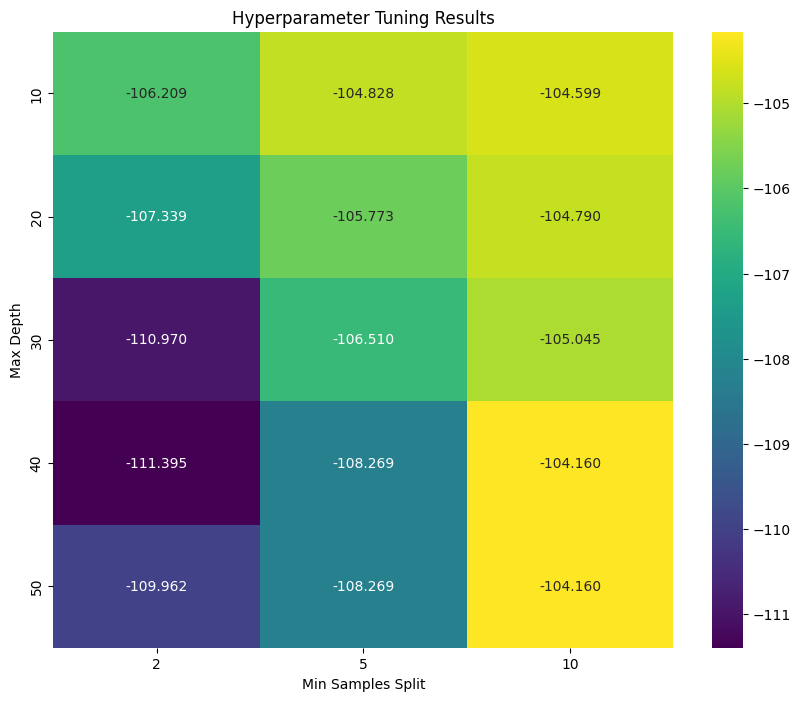

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'grid_search' is your GridSearchCV object
results = pd.DataFrame(grid_search.cv_results_)

# Create a pivot table of mean test scores for each combination of 'max_depth' and 'min_samples_split'
pivot_table = results.pivot_table(values='mean_test_score', 
                                  index='param_max_depth', 
                                  columns='param_min_samples_split')

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()
